In [1]:
import cnn3
from cnn3 import CNN3
from cnn3 import nn
from cnn3 import trainloader, testloader
from cnn3 import torch, optim
from cnn3 import tqdm
from cnn3 import np

from cnn3 import num_class_c1, num_class_c2, num_class_c3
from cnn3 import labels_c_1,labels_c_2, labels_c_3

from telegramBot import Terminator

In [2]:
cnn3.torch.autograd.set_detect_anomaly(False);
cnn3.torch.autograd.profiler.emit_nvtx(False);
cnn3.torch.autograd.profiler.profile(False);

In [3]:
class HCNN3(CNN3):

    def __init__(self, learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print = 512, switch_point = None, custom_training = False, training_size = 50000):

        super().__init__(learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, 
                 every_print, switch_point, custom_training, training_size)

        self.layer1  = nn.Conv2d(3, 64, (3,3), padding = 'same', bias = False)
        self.layer2  = nn.BatchNorm2d(64)
        self.layer3  = nn.Conv2d(64, 64, (3,3), padding = 'same', bias = False)
        self.layer4  = nn.BatchNorm2d(64)
        self.layer5  = nn.MaxPool2d((2,2), stride = (2,2))

        self.layer6  = nn.Conv2d(64, 128, (3,3), padding = 'same', bias = False)
        self.layer7  = nn.BatchNorm2d(128)
        self.layer8  = nn.Conv2d(128, 128, (3,3), padding = 'same', bias = False)
        self.layer9  = nn.BatchNorm2d(128)
        self.layer10 = nn.MaxPool2d((2,2), stride = (2,2))

        self.layerb11 = nn.Linear(8*8*128, 128, bias = False)
        self.layerb12 = nn.BatchNorm1d(128)
        self.layerb13 = nn.Dropout(0.5)
        self.layerb14 = nn.Linear(128, 128, bias = False)
        self.layerb15 = nn.BatchNorm1d(128)
        self.layerb16 = nn.Dropout(0.5)
        self.layerb_mid = nn.Linear(128, 128)
        self.layerb17 = nn.Linear(128, self.num_c_1)
        
        self.layerb27 = nn.Linear(128, self.num_c_2)
        self.layerb27_ = nn.Linear(self.num_c_1, self.num_c_2)
        
        self.layerb37 = nn.Linear(128, self.num_c_3)
        self.layerb37_ = nn.Linear(self.num_c_2, self.num_c_3)


        self.optimizer = optim.SGD(self.parameters(), lr = self.learning_rate[0], 
                                   momentum = self.momentum, nesterov = self.nesterov)
        self.criterion = nn.CrossEntropyLoss()


    def forward(self, x):

        # block 1
        z = self.layer1(x)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.activation(z)
        z = self.layer4(z)
        z = self.layer5(z)

        # block 2
        z = self.layer6(z)
        z = self.activation(z)
        z = self.layer7(z)
        z = self.layer8(z)
        z = self.activation(z)
        z = self.layer9(z)
        z = self.layer10(z)
        
        z = torch.flatten(z, start_dim = 1)

        # branch 1
        z = self.layerb11(z)
        z = self.activation(z)
        z = self.layerb12(z)
        z = self.layerb13(z)
        z = self.layerb14(z)
        z = self.activation(z)
        z = self.layerb15(z)
        z = self.layerb16(z)
        z = self.layerb_mid(z)
        z = self.activation(z)

        # projections
        ort2, ort3 = self.project(z)

        # branch 1
        b1 = self.layerb17(z)
        
        # branch 2
        b2 = self.layerb27(ort2) + self.layerb27_(b1.clone().detach())

        # branch 3
        b3 = self.layerb37(ort3) + self.layerb37_(b2.clone().detach())

        return b1, b2, b3

In [4]:
learning_rate = [3e-3, 5e-4]
momentum = 0.9
nesterov = True
epochs = 20
every_print = 64
switch_point = 9

In [5]:
bot = Terminator()
cnn = HCNN3(learning_rate, momentum, nesterov, trainloader, testloader, 
                 epochs, num_class_c1, num_class_c2, num_class_c3, labels_c_1, labels_c_2, labels_c_3, every_print, switch_point)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [1:04:07<00:00, 349.77s/it]


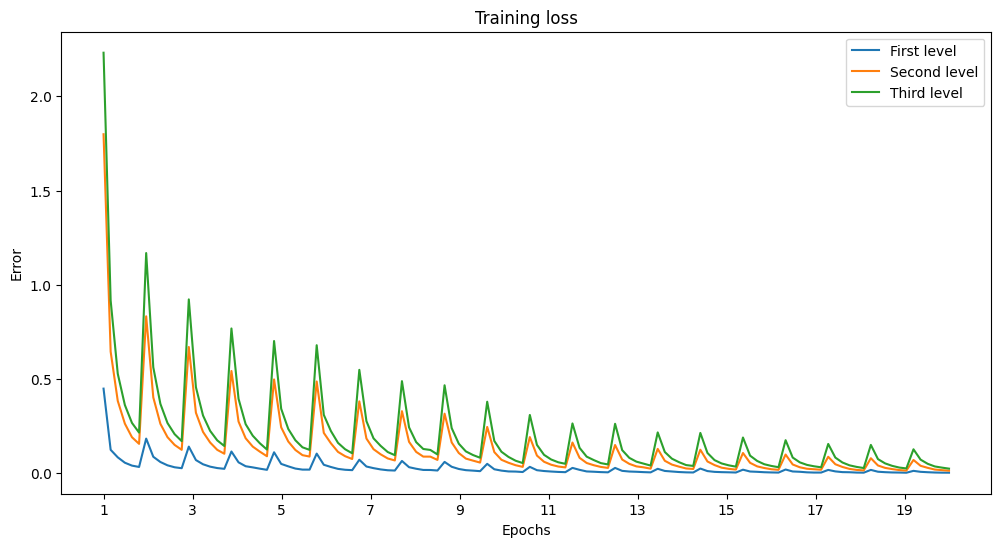

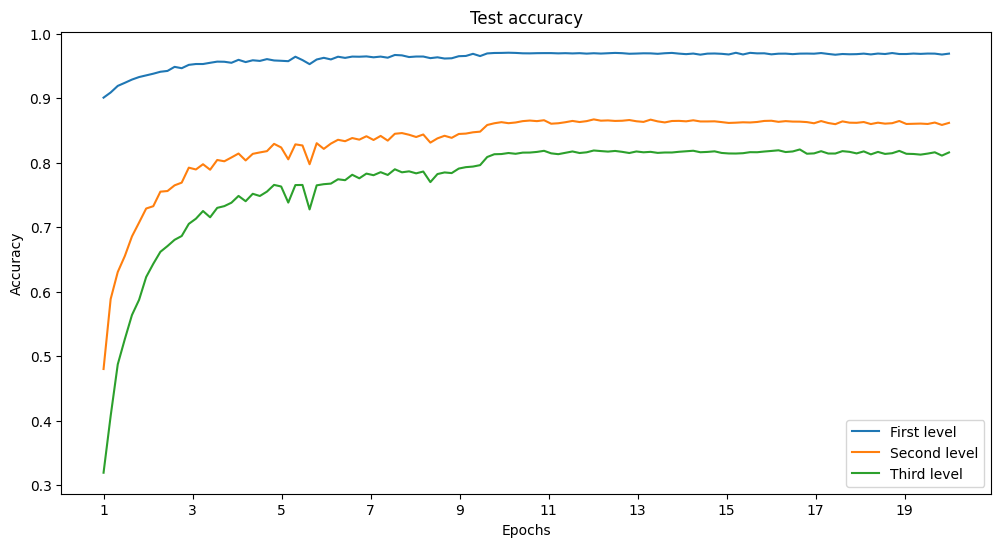

In [6]:
err = False
filename = "models/H_oca"

try:
    cnn.train_track(filename)
    cnn.save_model(filename)
    msg = cnn.test(mode = "write", filename = filename)
    cnn.write_configuration(filename)
    
except Exception as errore:
    err = errore

if err is False:
    bot.sendMessage("Programma terminato correttamente\n\n\nPerformance:\n\n"+msg)
else:
    bot.sendMessage("Programma NON terminato correttamente\nTipo di errore: "+err.__class__.__name__+"\nMessaggio: "+str(err))
    raise err